<h2 style='text-align: center;'>ID5004: AI in Predictive Maintenance, Reliability, and
Warranty
Assignment: Multivariate Statistics and Fault Detection</h2>

<h3 style='text-align: center;'>Author - Aloy Banerjee</h3>
<h3 style='text-align: center;'>Roll No. CH22M503</h3>

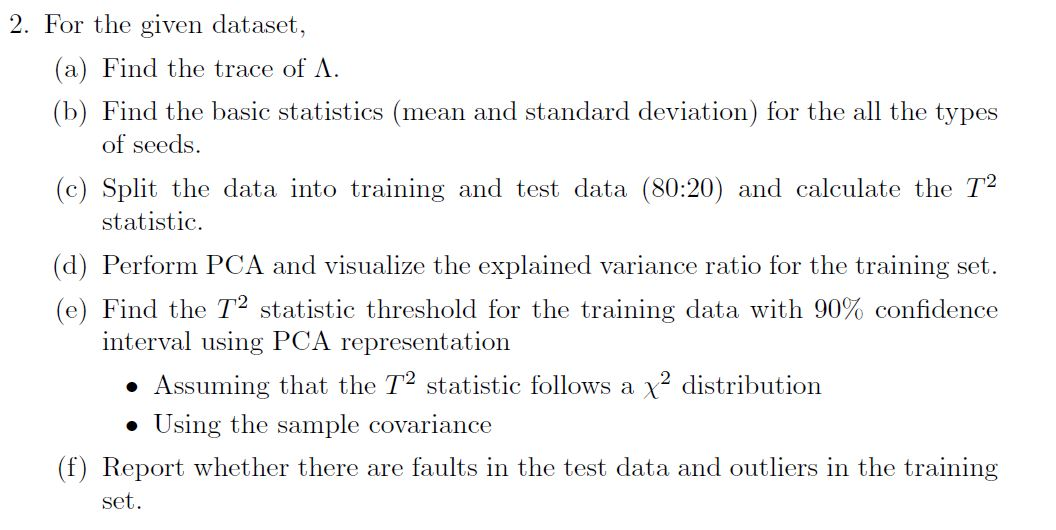

#### Importing Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA

from scipy.stats import f
from scipy.stats import chi2

In [2]:
# Use seaborn style aesthetics
sns.set_style('darkgrid')

#### Common variable

In [3]:
scaler = StandardScaler()
dataset_whole = pd.read_csv('seeds.csv')
unique_type = np.unique(dataset_whole['Type'])
variance_consideration = 0.95
alpha_90 = 0.1   # 90% confidence level (10% significance level)
alpha_95 = 0.05  # 95% confidence level (5% significance level)
alpha_99 = 0.01  # 99% confidence level (1% significance level)
seed = 719

#### Common Functionality

In [39]:
def dataProcessing(dataset, scaler):
    """
    Preprocesses the dataset by dropping the 'Type' column, scaling the data, and returning both 
    the original and scaled datasets.

    Args:
        dataset (DataFrame): The input dataset.
        scaler (object): The scaler object for data scaling.

    Returns:
        dataset (DataFrame): The preprocessed original dataset.
        dataset_scale (ndarray): The scaled dataset.
    """
    # Drop the 'Type' column from the dataset
    dataset = dataset.drop('Type', axis=1)
    
    # Display descriptive statistics of the whole dataset
    display(dataset_whole.describe())
    
    # Display information about the dataset
    display(dataset_whole.info())
    
    # Fit the scaler on the dataset and transform the dataset
    #scaler.fit(dataset)
    dataset_scale = preprocessing.scale(dataset)    
    
    # Print the scaled dataset
    print(dataset_scale)
    
    return dataset, dataset_scale    

def eigendecomposition(dataset, meanshifting):
    """
    Performs eigendecomposition on the dataset, optionally applying mean shifting.

    Args:
        dataset (ndarray): The input dataset.
        meanshifting (bool): Whether to apply mean shifting.

    Returns:
        covarince_mat (ndarray): The covariance matrix.
        eigenvalues (ndarray): The eigenvalues.
        eigenvectors (ndarray): The eigenvectors.
    """
    # Apply mean shifting if meanshifting is True
    if meanshifting:
        dataset_meaned = (dataset - np.mean(dataset, axis=0))
    else:
        dataset_meaned = dataset        
    
    # Calculate the length of the dataset
    length = len(dataset_meaned)
    
    # Calculate the covariance matrix
    covarince_mat = (1/(length-1)) * (dataset_meaned.T @ dataset_meaned)
    
    # Display the covariance matrix
    display(covarince_mat)
    
    # Perform eigendecomposition on the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covarince_mat)
    
    # Print the shape of the covariance matrix, eigenvalues, and eigenvectors
    print("Covariance matrix shape:", covarince_mat.shape)
    print("Eigen Vector shape:", eigenvectors.shape)
    print("Eigen Value shape:", eigenvalues.shape)
    print("Eigen Vector:", eigenvectors)
    print("Eigen Value:", eigenvalues)
    
    return covarince_mat, eigenvalues, eigenvectors

def datasplitting(dataset, dataset_whole):
    """
    Splits the dataset into training and test sets.

    Args:
        dataset (DataFrame): The input dataset.
        dataset_whole (DataFrame): The complete dataset.

    Returns:
        X_train (DataFrame): The training features.
        X_test (DataFrame): The test features.
        y_train (Series): The training labels.
        y_test (Series): The test labels.
    """
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, dataset_whole['Type'], test_size=0.2, random_state=seed)
    
    return X_train, X_test, y_train, y_test

def tsquaredStat(eigenvalues, eigenvectors, data, dataset_type):
    """
    Calculates the T-squared statistic for each data point.

    Args:
        eigenvalues (ndarray): The eigenvalues.
        eigenvectors (ndarray): The eigenvectors.
        data (DataFrame): The input data.
        dataset_type (str): The type of dataset.

    Returns:
        Lambda (ndarray): The diagonal matrix of eigenvalues.
        t_squared_values (list): The list of T-squared values.
        sum_t_squared_val (float): The sum of T-squared values.
    """
    # Sort the eigenvalues and eigenvectors in descending order
    eigenvalue_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[eigenvalue_indices]
    eigenvectors_sorted = eigenvectors[:, eigenvalue_indices]
    Lambda = np.diag(eigenvalues_sorted)
    Lambda_inv = np.diag(1 / np.diag(Lambda)) #np.linalg.inv(Lambda)
    t_squared_values = []
    data_array = np.array(data)
    sum_t_squared_val = 0
    for i in range(len(data_array)):
        t_squared = 0
        data_loop = data_array[i, :].reshape(-1,1)
        t_squared = data_loop.T @ eigenvectors_sorted @ Lambda_inv @ eigenvectors_sorted.T @ data_loop
        sum_t_squared_val += t_squared
        t_squared_values.append(t_squared[0][0])     
    
    
    Z = ((np.linalg.inv(np.sqrt(Lambda))).dot(eigenvectors_sorted.T)).dot(data.T)
    T_squared = np.diag(Z.T@Z)    
    print('T Squared Values in a without PCA: \n', T_squared)
    
    # Print the dataset type
    print(f'{dataset_type} :')
    
    # Print the T-squared values
    print('T Squared Values with PCA: \n', t_squared_values)
    
    # Print the sum of T-squared values
    print('Sum of T Squared Values : ', sum_t_squared_val[0][0])
    
    return Lambda, t_squared_values, sum_t_squared_val[0][0]

def pc_required(explained_variances):
    '''
    Determine the explained variation in comparison to a predetermined threshold value, 
    and then provide the number of principle components to be chosen.
    '''   
    # Find the number of principal components that explain the desired variance threshold
    return np.argmax(np.cumsum(explained_variances) >= variance_consideration) + 1

def perform_PCA(input_data):
    """
    Performs Principal Component Analysis (PCA) on the input data.

    Args:
        input_data (ndarray): The input data.

    Returns:
        considerable_PC (int): The number of considerable principle components.
        input_data_transformed (ndarray): The transformed input data.
    """
    # Create a PCA object
    pca = PCA()

    # Fit the PCA model to the input data
    pca.fit(input_data)

    # Transform the input data using the PCA model
    input_data_transformed = pca.transform(input_data)

    # Obtain the explained variance ratio for each principal component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Calculate the cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Get the total number of principal components
    num_components = len(explained_variance_ratio)

    # Determine the number of considerable principle components based on a threshold
    considerable_PC = pc_required(explained_variance_ratio)

    # Print the number of total components and the number of considerable principle components
    print(f'Number of total component : {num_components}')
    print('Considerable Principle Component : ', considerable_PC)

    # Create a scree plot to visualize the explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, num_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.xticks(np.arange(1, num_components + 1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print the explained variance ratio for each principal component
    print("Explained Variance Ratio:")
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"Principal Component {i+1}: {ratio:.4f}")

    # Print the cumulative explained variance for each principal component
    print("\nCumulative Explained Variance:")
    for i, var in enumerate(cumulative_variance):
        print(f"Principal Components 1-{i+1}: {var:.4f}")

    return considerable_PC, input_data_transformed, explained_variance_ratio

def statisticalAnalysis(inputdata, considerable_PC, transformed_data, alpha):
    """
    Performs statistical analysis on the transformed data.

    Args:
        inputdata (ndarray): The input data.
        considerable_PC (int): The number of considerable principle components.
        transformed_data (ndarray): The transformed data.
        alpha (float): The significance level.

    Returns:
        None
    """
    # Part 1 
    print('Part 1 : Assuming that the T2 statistic follows a χ2 distribution')
    # Calculate the T2 statistic threshold as per input alpha
    total_num_features = transformed_data.shape[1]
    print("Total Number of Features:", total_num_features)
    print('Considerable Principle Component : ', considerable_PC)
    
    # Degrees of freedom for the chi-square distribution
    dof = considerable_PC # number of Considerable Principle Component 
    print('Degree of Freedom', dof)

    # Calculate the T2 statistic threshold using the chi-square distribution    
    threshold = chi2.ppf(1 - alpha, df=dof)
    print("T2 Statistic Threshold:", threshold)


    # Part 2
    print('Part 2 : Using sample covariance')
    # Calculating T2 statistic threshold when sample covariance is used
    dfn = considerable_PC  # Degrees of freedom numerator
    dfd = inputdata.shape[0] - considerable_PC  # Degrees of freedom denominator

    # Calculate the critical value of F-distribution
    critical_value = f.ppf(1 - alpha, dfn, dfd)
    print("Critical value F_alpha(a, n-a):", critical_value)

    # Calculating T^2 statistic threshold
    n = inputdata.shape[0] - considerable_PC
    a = considerable_PC
    T_2_alpha = ((a * (n - 1) * (n + 1)) / (n * (n - a))) * critical_value
    print("T2 Statistic Threshold:", T_2_alpha)   
    
def outlier_threshold(alpha, input_data, considerablePC):
    """
    This function calculates the threshold for identifying outliers based on Hotelling's T-square 
    distribution and the F-distribution. This is used in multivariate outlier detection.

    Args:
    
    alpha : float
        The significance level for the F-distribution. This is used to control the Type I error 
        rate, i.e., the probability of falsely identifying an observation as an outlier.

    input_data : array-like
        A 2-dimensional numpy array or pandas DataFrame containing the multivariate data. Each 
        row represents an observation and each column represents a variable.

    considerablePC : int
        The number of principal components to be considered for outlier detection. This should be 
        less than or equal to the number of variables (columns) in the input data.

    Returns:
    
    float
        The threshold for identifying outliers. Observations with a T-square value greater than 
        this threshold are identified as outliers.    
    """
    n = input_data.shape[0]
    a = considerablePC
    f_alpha = f.ppf(alpha, a, n - a - 1)    
    threshold_outlier= ((n - 1) ** 2 * (a / (n - a - 1)) * f_alpha) / (n * (1 + (a / (n - a - 1))))
    return threshold_outlier

def fault_threshold(alpha, input_data, considerablePC):
    """
    This function calculates the threshold for identifying fault based on Hotelling's T-square 
    distribution and the F-distribution. This is used in multivariate fault detection.

    Args:
    
    alpha : float
        The significance level for the F-distribution. This is used to control the Type I error 
        rate, i.e., the probability of falsely identifying an observation as an fault.

    input_data : array-like
        A 2-dimensional numpy array or pandas DataFrame containing the multivariate data. Each 
        row represents an observation and each column represents a variable.

    considerablePC : int
        The number of principal components to be considered for outlier detection. This should be 
        less than or equal to the number of variables (columns) in the input data.

    Returns:
    
    float
        The threshold for identifying faults. Observations with a T-square value greater than 
        this threshold are identified as faults.    
    """
    n = input_data.shape[0]
    a = considerablePC
    f_alpha = f.ppf(alpha, a, n - a)
    fault_threshold= ((a(n-1)(n+1))/(n(n-a)))*f_alpha
    return fault_threshold


def generate_ellipsoid(center, radii, rotation, num_points=100):
    """
    Generate points on an ellipsoid surface given the center, radii, and rotation matrix.

    Parameters:
        center (numpy.ndarray): The center point of the ellipsoid.
        radii (numpy.ndarray): The radii of the ellipsoid in the x, y, and z directions.
        rotation (numpy.ndarray): The rotation matrix for orienting the ellipsoid.
        num_points (int): The number of points to generate on the ellipsoid surface. Default is 100.

    Returns:
        numpy.ndarray: Array of shape (num_points, num_points, 3) containing the points on the ellipsoid surface.

    """

    # Generate angles u and v for parameterizing the ellipsoid surface
    u = np.linspace(0, 2 * np.pi, num_points)
    v = np.linspace(0, np.pi, num_points)

    # Calculate the x, y, and z coordinates for each point on the ellipsoid surface
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

    # Stack the x, y, and z coordinates to form the ellipsoid points array
    ellipsoid = np.stack((x, y, z), axis=-1)

    # Apply rotation and translation to each point on the ellipsoid surface
    for i in range(num_points):
        for j in range(num_points):
            ellipsoid[i, j] = np.dot(rotation, ellipsoid[i, j]) + center

    # Return the array of points on the ellipsoid surface
    return ellipsoid
  

#### Data Loading & Processing

In [5]:
dataset, dataset_scale = dataProcessing(dataset_whole, scaler)

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,14.918744,14.595829,0.870811,5.643151,3.265533,3.699217,5.420653,1.994975
std,2.919976,1.310445,0.023320,0.443593,0.378322,1.471102,0.492718,0.813382
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.330000,13.470000,0.857100,5.267000,2.954500,2.570000,5.046000,1.000000
50%,14.430000,14.370000,0.873400,5.541000,3.245000,3.631000,5.228000,2.000000
75%,17.455000,15.805000,0.886800,6.002000,3.564500,4.799000,5.879000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.315000,6.550000,3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             199 non-null    float64
 1   Perimeter        199 non-null    float64
 2   Compactness      199 non-null    float64
 3   Kernel.Length    199 non-null    float64
 4   Kernel.Width     199 non-null    float64
 5   Asymmetry.Coeff  199 non-null    float64
 6   Kernel.Groove    199 non-null    float64
 7   Type             199 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


None

[[ 0.11716431  0.18679667  0.0081443  ...  0.12313474 -1.00737062
  -0.40826475]
 [-0.01330197 -0.01975993  0.44234139 ...  0.17878306 -1.82718718
  -0.9454197 ]
 [-0.21586804 -0.38697165  1.46979786 ...  0.18938275 -0.68162472
  -1.21196249]
 ...
 [-0.59010028 -0.71593216  0.75186803 ... -0.08885888  3.14554887
  -0.74195192]
 [-1.05703224 -1.06019315 -0.80436312 ... -1.13822732 -0.06897709
  -0.76636805]
 [-0.89909937 -0.96073998 -0.10362921 ... -0.77253832  1.32055406
  -0.72770917]]


## a) Find the trace of Λ.

In [6]:
covarince_mat_scale, eigenvalues_scale, eigenvectors_scale = eigendecomposition(dataset_scale, True)

array([[ 1.00505051,  0.99945967,  0.61296771,  0.95592951,  0.97588352,
        -0.22394581,  0.86708441],
       [ 0.99945967,  1.00505051,  0.5345268 ,  0.97785806,  0.95027092,
        -0.21210008,  0.89403606],
       [ 0.61296771,  0.5345268 ,  1.00505051,  0.3759002 ,  0.7660163 ,
        -0.33106381,  0.22816301],
       [ 0.95592951,  0.97785806,  0.3759002 ,  1.00505051,  0.8670369 ,
        -0.17056152,  0.9368318 ],
       [ 0.97588352,  0.95027092,  0.7660163 ,  0.8670369 ,  1.00505051,
        -0.25440081,  0.75200687],
       [-0.22394581, -0.21210008, -0.33106381, -0.17056152, -0.25440081,
         1.00505051, -0.00336631],
       [ 0.86708441,  0.89403606,  0.22816301,  0.9368318 ,  0.75200687,
        -0.00336631,  1.00505051]])

Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[ 0.44444526  0.0268951  -0.02541939  0.19763627  0.19751625 -0.73412145
  -0.42905925]
 [ 0.44156742  0.08298812  0.06019769  0.30034829  0.16637062  0.67153918
  -0.47503082]
 [ 0.27791499 -0.52535969 -0.63238211 -0.34000075 -0.32627308  0.07310414
  -0.13947927]
 [ 0.42412605  0.200075    0.21443932  0.25098045 -0.76832639 -0.0463691
   0.28042137]
 [ 0.43293659 -0.11572453 -0.2151238   0.20373132  0.46870015  0.03700686
   0.70024261]
 [-0.1157433   0.72122562 -0.67513087  0.09326364 -0.04045161  0.00383945
  -0.01691821]
 [ 0.38669933  0.37788656  0.21853787 -0.80120818  0.12333864  0.0349609
   0.03920887]]
Eigen Value: [5.05691778e+00 1.20519035e+00 6.79631565e-01 6.85475795e-02
 1.89074688e-02 8.16380060e-04 5.34241202e-03]


In [7]:
trace_scale = np.trace(np.diag(eigenvalues_scale))
print("Trace of Λ with scalling:", trace_scale)

Trace of Λ with scalling: 7.035353535353538


###  Conclusion of a)

###### We have clauclated trace of Λ derived from the scaled data using eigen value decomposition. In a scalled data trace is appear as approximately 7.035.

## b) Find the basic statistics (mean and standard deviation) for the all the types of seeds.

In [8]:
unique_type

array([1, 2, 3], dtype=int64)

#### Five summary table for individual seeds type

In [9]:
# Group the data by seed type
grouped_data = dataset_whole.groupby('Type')
print(grouped_data)
df_groupdata_stats = grouped_data.describe()
display(grouped_data.describe())
df_groupdata_stats.to_csv('groupwiseStat.csv', sep=',', index=False, encoding='utf-8')

Area                                                            \
     count       mean       std    min    25%    50%      75%    max   
Type                                                                   
1     66.0  14.354394  1.178117  11.23  13.75  14.36  15.0450  17.08   
2     68.0  18.370147  1.413670  15.38  17.35  18.72  19.1425  21.18   
3     65.0  11.881077  0.720822  10.59  11.27  11.84  12.3800  13.37   

     Perimeter             ... Asymmetry.Coeff        Kernel.Groove            \
         count       mean  ...             75%    max         count      mean   
Type                       ...                                                  
1         66.0  14.306818  ...         3.36175  6.685          66.0  5.087197   
2         68.0  16.156912  ...         4.45375  6.682          68.0  6.026515   
3         65.0  13.256154  ...         5.46200  8.315          65.0  5.125415   

                                                       
           std    min     25%     50%      75%    max  
Type                                                   
1     0.259822  4.519  4.9245  5.0940  5.22150  5.877  
2     0.246663  5.144  5.8785  5.9815  6.18725  6.550  
3     0.160033  4.794  5.0030  5.1320  5.26300  5.491  

[3 rows x 56 columns]

##### Mean of the dataset

In [37]:
#Mean information separately 
print(f'Mean of the given data based on type :')
grouped_data.mean()

Mean of the given data based on type :


,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove
Type,,,,,,,
1,14.354394,14.306818,0.879892,5.513000,3.247485,2.690670,5.087197
2,18.370147,16.156912,0.882965,6.157838,3.678647,3.657250,6.026515
3,11.881077,13.256154,0.848874,5.236862,2.851677,4.767185,5.125415


##### Standard deviation of the dataset

In [36]:
#standard deviation information separately 
print(f'Standard Deviation of the given data based on type :')
grouped_data.std()

Standard Deviation of the given data based on type :


,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove
Type,,,,,,,
1,1.178117,0.559209,0.016349,0.228527,0.173251,1.198981,0.259822
2,1.413670,0.599224,0.015371,0.259336,0.185824,1.195293,0.246663
3,0.720822,0.347975,0.020807,0.136917,0.143343,1.237093,0.160033


###  Conclusion of b)

###### Basic statistical analysis has been done on the entire data. Initially we have calculated the 5 point summary table for each type in the main dataset and next as per the request we have separately display the mean and standard deviation for each type of the seed.

## c) Split the data into training and test data (80:20) and calculate the T2 statistic.

<h4 style='text-align: center;'> Formulation using PCA $T^{2} = x^{T}V \Lambda^{-1}V^{T}x$</h4>
<h4 style='text-align: center;'> Formulation without PCA $z = \Lambda^{-1/2}V^{T}x$, $T^{2} = z^{T}z$</h4>

In [12]:
X_train_scale, X_test_scale, y_train_scale, y_test_scale = datasplitting(dataset_scale, dataset_whole)

In [13]:
print("Scaled Training data shape:", X_train_scale.shape)
print("Scaled Test data shape:", X_test_scale.shape)

Scaled Training data shape: (159, 7)
Scaled Test data shape: (40, 7)


##### Analysis on train dataset

In [38]:
print('Analysis on Train dataset : ')
covarince_mat_scale, eigenvalues_scale, eigenvectors_scale = eigendecomposition(X_train_scale, True)
Lambda_train_scale, t_squared_values_train_scale, sum_t_squared_values_train_scale = tsquaredStat(eigenvalues_scale, eigenvectors_scale, X_train_scale, 'Scale Train Dataset')

Analysis on Train dataset : 


array([[ 0.96998048,  0.96334701,  0.59931379,  0.92219736,  0.95218448,
        -0.19894364,  0.82316815],
       [ 0.96334701,  0.96850848,  0.51743217,  0.94448966,  0.92483881,
        -0.18570187,  0.85134023],
       [ 0.59931379,  0.51743217,  1.01555981,  0.3575976 ,  0.76355007,
        -0.33623986,  0.19297432],
       [ 0.92219736,  0.94448966,  0.3575976 ,  0.97394067,  0.84478869,
        -0.14487271,  0.89443549],
       [ 0.95218448,  0.92483881,  0.76355007,  0.84478869,  0.99130419,
        -0.23276407,  0.71876968],
       [-0.19894364, -0.18570187, -0.33623986, -0.14487271, -0.23276407,
         1.01922112,  0.0104037 ],
       [ 0.82316815,  0.85134023,  0.19297432,  0.89443549,  0.71876968,
         0.0104037 ,  0.95110651]])

Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[ 0.4446199   0.0302841  -0.02601202  0.17782854  0.25661405 -0.72410249
  -0.42299081]
 [ 0.44110619  0.08797006  0.06025852  0.29272503  0.23821032  0.68145179
  -0.43272032]
 [ 0.2826643  -0.53341971 -0.62037301 -0.31025567 -0.34112073  0.08034061
  -0.17783444]
 [ 0.42370744  0.2026861   0.21185989  0.31944064 -0.7647388  -0.05492641
   0.211237  ]
 [ 0.43846746 -0.11065527 -0.21472648  0.13818673  0.41658418  0.01813921
   0.74594052]
 [-0.11016562  0.71878068 -0.68113547  0.07559293 -0.03357756  0.00527387
  -0.02006947]
 [ 0.37936947  0.36991302  0.23641493 -0.81214426  0.03932502  0.03834948
   0.02749006]]
Eigen Value: [4.87621224e+00 1.23797670e+00 6.89879269e-01 6.26560732e-02
 1.72535017e-02 8.33788927e-04 4.80969208e-03]
T Squared Values in a without PCA: 
 [ 8.13882491  1.23670108 21.09492629  8.92054082  5.02947442 11.69291696
  4.60229843  6.64995453  7.24398194  5.55438987

##### Analysis on test dataset

In [34]:
covarince_mat_test_scale, eigenvalues_test_scale, eigenvectors_test_scale = eigendecomposition(X_test_scale, True)
Lambda_test_scale, t_squared_values_test_scale, sum_t_squared_values_test_scale = tsquaredStat(eigenvalues_test_scale, eigenvectors_test_scale, X_test_scale, 'Scale Test Dataset')

array([[ 1.13229729,  1.12568774,  0.70343877,  1.06599423,  1.06738462,
        -0.28857338,  1.01649974],
       [ 1.12568774,  1.12742168,  0.63936708,  1.08059307,  1.04442736,
        -0.27675393,  1.03282628],
       [ 0.70343877,  0.63936708,  0.97893906,  0.48415369,  0.80978787,
        -0.33888431,  0.40086155],
       [ 1.06599423,  1.08059307,  0.48415369,  1.09253201,  0.94223017,
        -0.22563325,  1.06875441],
       [ 1.06738462,  1.04442736,  0.80978787,  0.94223017,  1.06502969,
        -0.31773586,  0.86903924],
       [-0.28857338, -0.27675393, -0.33888431, -0.22563325, -0.31773586,
         0.92912322, -0.00625093],
       [ 1.01649974,  1.03282628,  0.40086155,  1.06875441,  0.86903924,
        -0.00625093,  1.18596753]])

Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[ 4.43755633e-01  1.35550406e-02 -4.48321877e-03  2.41191150e-01
   7.65785043e-01  3.96784133e-01  2.89749674e-02]
 [ 4.40505415e-01  5.94693129e-02  7.95423757e-02  3.15432162e-01
  -6.35033126e-01  5.41325690e-01 -1.71280074e-02]
 [ 2.82566560e-01 -4.61304022e-01 -6.88789821e-01 -3.87372292e-01
  -6.17617370e-02  6.65763165e-02 -2.73164987e-01]
 [ 4.19449370e-01  1.82949927e-01  2.57486617e-01  5.74309983e-02
   1.26110919e-04 -4.55257840e-01 -7.16752506e-01]
 [ 4.18641631e-01 -1.30677040e-01 -2.08357050e-01  3.66209226e-01
  -7.59351250e-02 -5.81232960e-01  5.35297059e-01]
 [-1.20291136e-01  7.50720642e-01 -6.18501635e-01  1.78767194e-01
   4.30240281e-05 -5.51353321e-04 -8.62917895e-02]
 [ 4.04380401e-01  4.11521099e-01  1.64210848e-01 -7.23122992e-01
  -2.69355563e-02  2.16447994e-03  3.41357002e-01]]
Eigen Value: [5.71677422e+00 1.10712221e+00 5.73782798e-01 8.76936782e-02
 6.421819

###  Conclusion of c)
##### We have analyze the T squared statistics on the scaled data after splitting them into train and test set. In first cell we have given the report for train dataset and in next cell same report has been given for test dataset.
We have calculated the T Squared statistics using below two possible way,
- **Using PCA** : Using PCA method we have find out the eigen value and vector of the covariance matrix of the dataset and then perfom T Squared calculating using $T^{2} = x^{T}V \Lambda^{-1}V^{T}x$.
- **Without using PCA** : In this method without PCA we are using $z = \Lambda^{-1/2}V^{T}x$, $T^{2} = z^{T}z$ formulation to calculate the same.

##### Using both the formulation we are getting same value as the T Squared statistics.

## d)  Perform PCA and visualize the explained variance ratio for the training set.

Number of total component : 7
Considerable Principle Component :  3


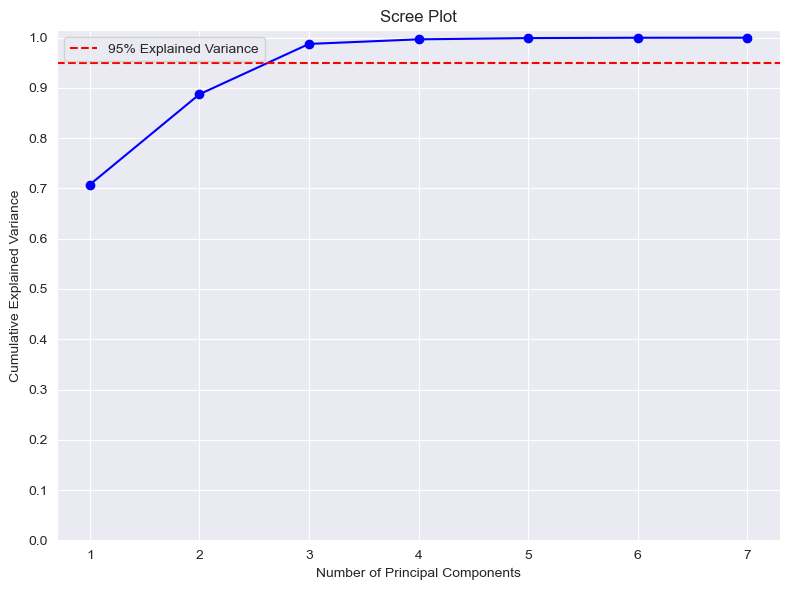

Explained Variance Ratio:
Principal Component 1: 0.7078
Principal Component 2: 0.1797
Principal Component 3: 0.1001
Principal Component 4: 0.0091
Principal Component 5: 0.0025
Principal Component 6: 0.0007
Principal Component 7: 0.0001

Cumulative Explained Variance:
Principal Components 1-1: 0.7078
Principal Components 1-2: 0.8874
Principal Components 1-3: 0.9876
Principal Components 1-4: 0.9967
Principal Components 1-5: 0.9992
Principal Components 1-6: 0.9999
Principal Components 1-7: 1.0000


(3,
 array([[ 2.91227405,  0.78722967,  0.42897615, ..., -0.02472031,
         -0.05352962,  0.00722962],
        [-1.20394502,  0.07443273,  0.25963188, ..., -0.06520818,
         -0.00970153, -0.01526807],
        [ 2.89880671, -2.54645106, -1.09249702, ..., -0.43710109,
          0.02350067, -0.02691593],
        ...,
        [-1.97989981, -0.48594054,  0.2770536 , ..., -0.01557391,
         -0.02190397, -0.00569306],
        [-3.18433125, -1.82110649, -1.02961763, ...,  0.12881505,
          0.16043915,  0.04483931],
        [-0.60008419, -0.46027835,  2.30203398, ..., -0.11540018,
         -0.06251794, -0.02797115]]),
 array([7.07762017e-01, 1.79687192e-01, 1.00133119e-01, 9.09426960e-03,
        2.50427433e-03, 6.98106891e-04, 1.21021010e-04]))

In [16]:
perform_PCA(X_train_scale)

###  Conclusion of d)
##### We are performing the PCA on a train dataset and based on the eigen values we have caluclated the explained variance for each principle component and plotted. While finalizing the minimum considerable principle components need to keep for further reconstruction we have considered to maintain 95% explained variance as a threshold. Considering the same we have got minimum 3 principle components should be reserve for further resconstruction. 

### e)  Find the T2 statistic threshold for the training data with 90% confidence interval using PCA representation
- Assuming that the T2 statistic follows a χ2 distribution
- Using the sample covariance

### Formulation 
<h4 style='text-align: center;'> T Squared threshold when actual covariance matrix is estimated from sample covariance :  $\frac{a(n-1)(n+1)F_{\alpha}}{n(n-a)}$ </h4>

Number of total component : 7
Considerable Principle Component :  3


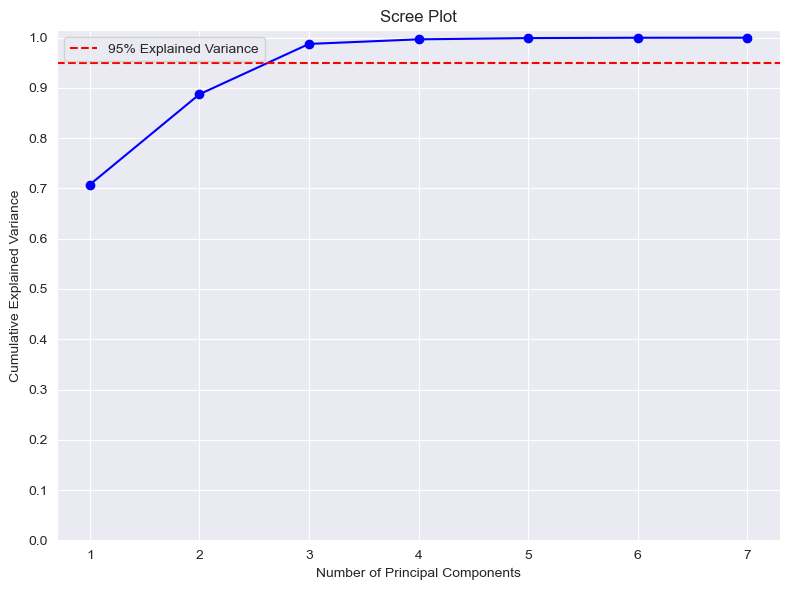

Explained Variance Ratio:
Principal Component 1: 0.7078
Principal Component 2: 0.1797
Principal Component 3: 0.1001
Principal Component 4: 0.0091
Principal Component 5: 0.0025
Principal Component 6: 0.0007
Principal Component 7: 0.0001

Cumulative Explained Variance:
Principal Components 1-1: 0.7078
Principal Components 1-2: 0.8874
Principal Components 1-3: 0.9876
Principal Components 1-4: 0.9967
Principal Components 1-5: 0.9992
Principal Components 1-6: 0.9999
Principal Components 1-7: 1.0000


In [17]:
considerable_PC_scale, transformed_data_scale, variance_explained_ratio_scale = perform_PCA(X_train_scale)

In [40]:
print('Conclusion :')
print('Result with scale data : ')
statisticalAnalysis(X_train_scale, considerable_PC_scale, transformed_data_scale, alpha_90) 

Conclusion :
Result with scale data : 
Part 1 : Assuming that the T2 statistic follows a χ2 distribution
Total Number of Features: 7
Considerable Principle Component :  3
Degree of Freedom 3
T2 Statistic Threshold: 6.251388631170325
Part 2 : Using sample covariance
Critical value F_alpha(a, n-a): 2.1192236622197966
T2 Statistic Threshold: 6.482064834102407


###  Conclusion of e) 
##### We have performed the analysis on scaled train data of the given dataset. The problem statement has two assumption to made. 
- Assuming that the T2 statistic follows a χ2 distribution
- Using sample covariance

As per the assumption and considering that there are only 3 considerable principle components we have achieved the threshold as below,

- **Assuming that the T2 statistic follows a χ2 distribution**
    - T2 Statistic Threshold: 6.251388631170325
- **Using sample covariance**
    - T2 Statistic Threshold: 6.482064834102407|

### f) Report whether there are faults in the test data and outliers in the training set.

### Outlier Detection : -
### Formulation:
<div align='center'> Outliers in the training set can be detected using the $T^{2}$ statistic for a selected confidence level = $\frac{(n-1)^{2}(a/(n-a-1))F_{\alpha}(a, n-a-1)}{n(1+(a/(n-a-1)))}$

#### Outlier Calculation

Number of total component : 7
Considerable Principle Component :  3


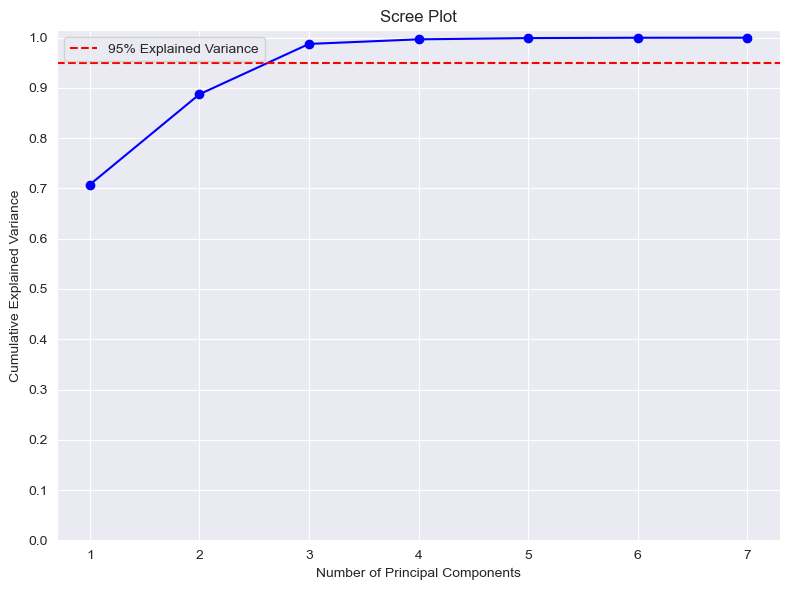

Explained Variance Ratio:
Principal Component 1: 0.7078
Principal Component 2: 0.1797
Principal Component 3: 0.1001
Principal Component 4: 0.0091
Principal Component 5: 0.0025
Principal Component 6: 0.0007
Principal Component 7: 0.0001

Cumulative Explained Variance:
Principal Components 1-1: 0.7078
Principal Components 1-2: 0.8874
Principal Components 1-3: 0.9876
Principal Components 1-4: 0.9967
Principal Components 1-5: 0.9992
Principal Components 1-6: 0.9999
Principal Components 1-7: 1.0000


In [60]:
considerable_PC_scale, transformed_data_scale, variance_explained_ratio_scale = perform_PCA(X_train_scale)

In [61]:
threshold_scale = outlier_threshold(alpha_90, X_train_scale, considerable_PC_scale)
print(f'Threshold for outlier identification using F Statistics: {threshold_scale}')

Threshold for outlier identification using F Statistics: 0.5799264538687628


In [62]:
covarince_mat_scale, eigenvalues_scale, eigenvectors_scale = eigendecomposition(dataset, True)

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove
Area,8.526259,3.805181,0.041530,1.231976,1.072631,-0.957144,1.241226
Perimeter,3.805181,1.717265,0.016253,0.565577,0.468748,-0.406831,0.574360
Compactness,0.041530,0.016253,0.000544,0.003869,0.006724,-0.011300,0.002608
Kernel.Length,1.231976,0.565577,0.003869,0.196775,0.144776,-0.110744,0.203731
Kernel.Width,1.072631,0.468748,0.006724,0.144776,0.143127,-0.140875,0.139474
Asymmetry.Coeff,-0.957144,-0.406831,-0.011300,-0.110744,-0.140875,2.164142,-0.002428
Kernel.Groove,1.241226,0.574360,0.002608,0.203731,0.139474,-0.002428,0.242771


Covariance matrix shape: (7, 7)
Eigen Vector shape: (7, 7)
Eigen Value shape: (7,)
Eigen Vector: [[-8.85169308e-01  9.36176492e-02 -2.62533402e-01 -2.03441900e-01
  -1.39443945e-01  2.78046562e-01 -2.53797953e-02]
 [-3.95839443e-01  5.31524997e-02  2.77882551e-01  5.88392440e-01
   5.72123257e-01 -2.92226998e-01  6.58781574e-02]
 [-4.25074480e-03 -2.98177972e-03 -5.78406038e-02 -5.81051325e-02
  -5.23641346e-02 -4.51665532e-02  9.94217923e-01]
 [-1.28578012e-01  2.85084775e-02  3.96668448e-01  4.29298306e-01
  -7.90540121e-01 -1.26721311e-01  3.08701969e-04]
 [-1.10984612e-01  8.07419729e-04 -3.16823362e-01 -2.39176432e-01
  -1.26755669e-01 -8.98649492e-01 -8.03831249e-02]
 [ 1.19540898e-01  9.90285180e-01 -6.58865305e-02  2.62037581e-02
  -2.99359809e-03  2.70061672e-03  1.14444388e-03]
 [-1.28951338e-01  8.32077767e-02  7.67103664e-01 -6.05673579e-01
   9.72559443e-02 -1.07782095e-01  9.15447308e-03]]
Eigen Value: [1.08516254e+01 2.04834826e+00 7.37914840e-02 1.27479228e-02
 2.756007

In [63]:
print(f'Lambda Train : {Lambda_train_scale}')
print(f'T Squared Value : {t_squared_values_train_scale}')
print(f'Sum of T Squared value : {sum_t_squared_values_train_scale}')

Lambda Train : [[4.87621224e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.23797670e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.89879269e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.26560732e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.72535017e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.80969208e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 8.33788927e-04]]
T Squared Value : [8.13882491384439, 1.2367010821001228, 21.094926288066432, 8.920540822092203, 5.029474418188186, 11.692916958298257, 4.6022984285373925, 6.649954533841717, 7.243981943230949, 5.554389868202854, 4.

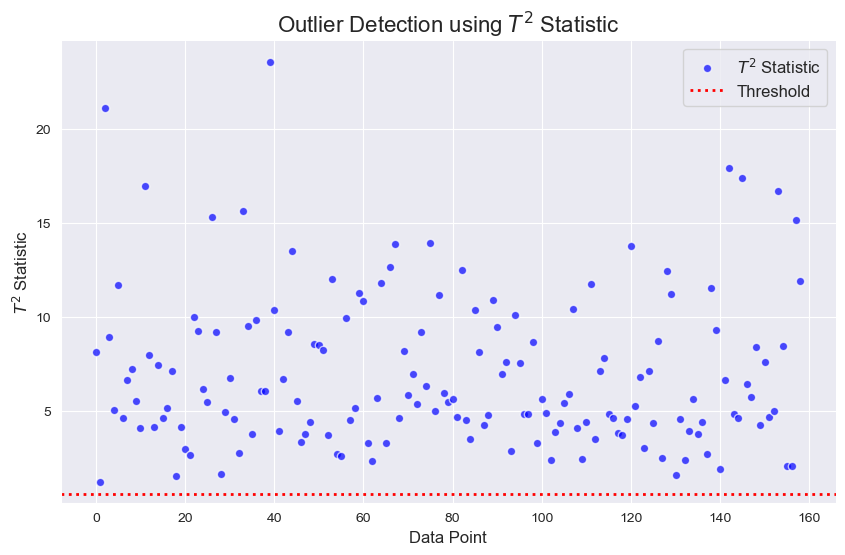

In [64]:
# Set up a larger figure size and grid layout
plt.figure(figsize=(10, 6))


# Create a scatter plot of the T^2 statistic values
scatter = plt.scatter(range(len(t_squared_values_train_scale)), t_squared_values_train_scale, label='$T^2$ Statistic', color='blue', edgecolor='white', alpha=0.7)

# Plot the threshold as a red dotted line
plt.axhline(y=threshold_scale, linestyle='dotted', color='red', linewidth=2, label='Threshold')


# Add labels and title to the plot
plt.xlabel('Data Point', fontsize=12)
plt.ylabel('$T^2$ Statistic', fontsize=12)
plt.title('Outlier Detection using $T^2$ Statistic', fontsize=16)

# Add a legend with custom fontsize
plt.legend(loc='best', fontsize=12)

# Remove top and right spines for better aesthetics
sns.despine(top=True, right=True)

# Show the plot
plt.show()


In [65]:
eigenvalue_indices = np.argsort(eigenvalues_scale)[::-1]
eigenvalues_sorted = eigenvalues_scale[eigenvalue_indices]
eigenvectors_sorted = eigenvectors_scale[:, eigenvalue_indices]
PCs = eigenvectors_scale[:,:3].T@X_train_scale.T

In [66]:
PCs.shape

(3, 159)

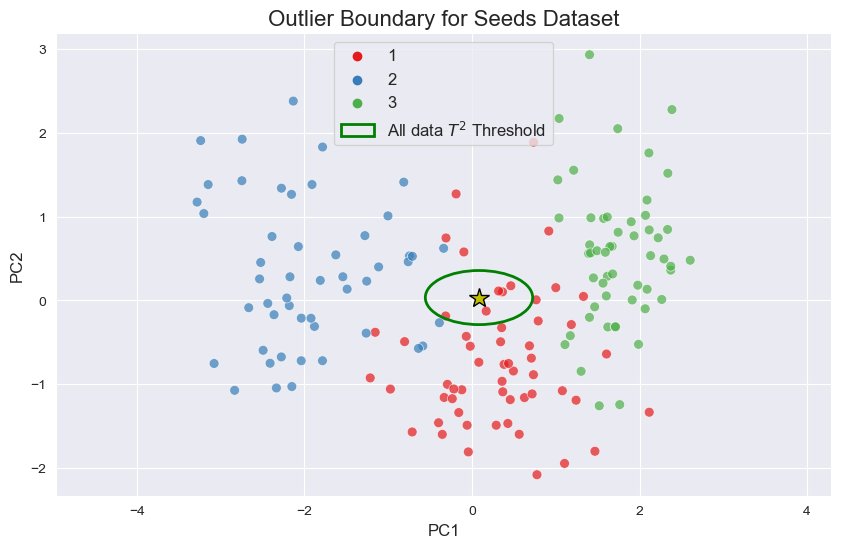

In [67]:
# Set up a larger figure size and grid layout
plt.figure(figsize=(10, 6))

# Define color palette for scatterplot
color_palette = sns.color_palette("Set1", np.unique(np.array(y_train_scale).reshape(-1)).shape[0])

# Creating a scatter plot of the transformed data
scatter = sns.scatterplot(x=PCs[0, :].T, y=PCs[1, :].T, hue=np.array(y_train_scale).reshape(-1), palette=color_palette, s=50, edgecolor='white', alpha=0.7)

# Set equal aspect ratio
plt.gca().set_aspect('equal', 'datalim')

# Adding the T2 threshold ellipse for class 3 data
ellipse = Ellipse(xy=np.mean(PCs.T, axis=0), 
                  width=2 * np.sqrt(threshold_scale) * np.sqrt(variance_explained_ratio_scale[0]),
                  height=2 * np.sqrt(threshold_scale) * np.sqrt(variance_explained_ratio_scale[1]), 
                  edgecolor='green', linewidth=2, facecolor='none', label='All data $T^2$ Threshold')

# Adding the ellipse to the plot
scatter.add_patch(ellipse)

# Highlight the center of the ellipse with yellow star marker
plt.plot(np.mean(PCs.T, axis=0)[0], np.mean(PCs.T, axis=0)[1], "y*", markersize=15, markeredgecolor='black')

# Adding labels and title
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('Outlier Boundary for Seeds Dataset', fontsize=16)

# Add a legend with custom fontsize
plt.legend(loc='best', fontsize=12)

# Remove top and right spines for better aesthetics
sns.despine(top=True, right=True)

# Show the plot
plt.show()



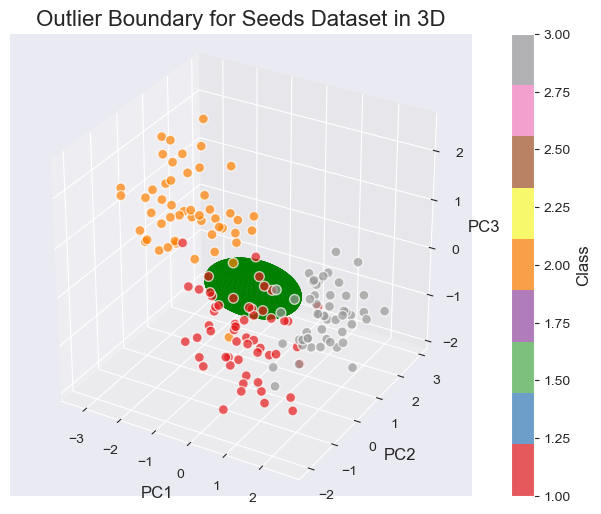

In [68]:
# Set up a larger figure size and grid layout
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Creating a scatter plot of the transformed data
scatter = ax.scatter(xs=PCs[0, :].T, ys=PCs[1, :].T, zs=PCs[2, :].T, c=np.array(y_train_scale).reshape(-1),
                     cmap='Set1', s=50, edgecolor='white', alpha=0.7)

# Set equal aspect ratio
ax.set_box_aspect([1, 1, 1])

# Generate points on the ellipsoid surface
center = np.mean(np.array([PCs[0, :].T, PCs[1, :].T, PCs[2, :].T]), axis=1)
radii = 2 * np.sqrt(threshold_scale) * np.sqrt(variance_explained_ratio_scale)
rotation = np.eye(3)
ellipsoid_points = generate_ellipsoid(center, radii, rotation)

# Plot the ellipsoid surface
ax.plot_surface(ellipsoid_points[..., 0], ellipsoid_points[..., 1], ellipsoid_points[..., 2],
                edgecolor='green', linewidth=1, alpha=0.2, color='lightgray')

# Highlight the center of the ellipsoid with a yellow star marker
ax.scatter(center[0], center[1], center[2], marker='*', color='yellow', s=100, edgecolor='black')

# Adding labels and title
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
ax.set_title('Outlier Boundary for Seeds Dataset in 3D', fontsize=16)

# Add a colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Class', fontsize=12)

# Add a legend with custom fontsize
#ax.legend(loc='best', fontsize=12)

# Remove top and right spines for better aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()




### Conclusion on Outlier Detection : 
###### 1. In the context of Principal Component Analysis (PCA), $T^2$ statistic is an effective tool for detecting outliers. This is essentially a multivariate generalization of Student's t-statistic and it measures the distance of a data point in the transformed space from the origin.

###### 2.By projecting our multi-dimensional dataset into a lower-dimensional space via PCA, we created a scatter plot of the transformed data. As seen in our visualizations, the elliptical boundary (illustrated in purple) encapsulates the majority of our data points. This boundary represents the calculated $T^2$ statistic threshold, beyond which points are considered unusual with respect to the multivariate distribution of our dataset.

###### 3.Thus, all data points residing outside the purple ellipse can be regarded as outliers in the context of multivariate analysis. These points deviate significantly from the overall distribution, therefore raising flags for further investigation.

###### 4.Our previous plot delves deeper into the outlier detection using $T^2$ statistic, where we have indicated the threshold boundary with a red dotted line. Again, all data points that fall above this threshold are potential outliers.

### Fault Identification : -

### Formulation:
<div align='center'> Faults in the test set can be detected using the $T^{2}$ statistic for a selected confidence level = $\frac{a(n-1)(n+1)F_{\alpha}}{n(n-a)}$

In [28]:
fault_threshold = outlier_threshold(alpha_90, X_test_scale, considerable_PC_scale)
print(f'Threshold for fault identification using F Statistics: {threshold_scale}')

Threshold for fault identification using F Statistics: 0.5799264538687628


In [29]:
print(f'Lambda Train : {Lambda_train_scale}')
print(f'T Squared Value : {t_squared_values_train_scale}')
print(f'Sum of T Squared value : {sum_t_squared_values_train_scale}')

Lambda Train : [[4.87621224e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.23797670e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.89879269e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.26560732e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.72535017e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.80969208e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 8.33788927e-04]]
T Squared Value : [8.13882491384439, 1.2367010821001228, 21.094926288066432, 8.920540822092203, 5.029474418188186, 11.692916958298257, 4.6022984285373925, 6.649954533841717, 7.243981943230949, 5.554389868202854, 4.

<h2>Formulation</h2>
<h3 style='text-align: center;'> $z = \Lambda^{-1/2}V^{T}x$</h3>
<h3 style='text-align: center;'> $T^{2} = z^{T}z$</h3>

In [30]:
Z_test = ((np.linalg.inv(np.sqrt(Lambda_train_scale[:3,:3]))).dot(eigenvectors_sorted[:, :3].T)).dot(X_test_scale.T)
T_squared_test = np.diag(Z_test.T@Z_test)
print("T_squared statistic for Test dataset : \n\n", T_squared_test)

T_squared statistic for Test dataset : 

 [1.74809135 3.8938561  1.90049121 2.04068736 1.67187062 2.86397734
 1.98031613 0.40968427 1.2848287  2.34292223 2.34188586 1.61450405
 4.00724456 1.98155746 2.96449647 0.63923297 1.329757   2.39938717
 8.78891212 1.46020373 8.90820485 0.68458644 1.06388663 0.13639874
 5.1178487  2.38874956 1.33851576 1.75597546 3.47676949 9.70062046
 2.58971386 6.1214551  0.19638774 5.99450397 1.62049245 1.64395022
 3.76608807 2.0965247  3.03129702 4.21132882]


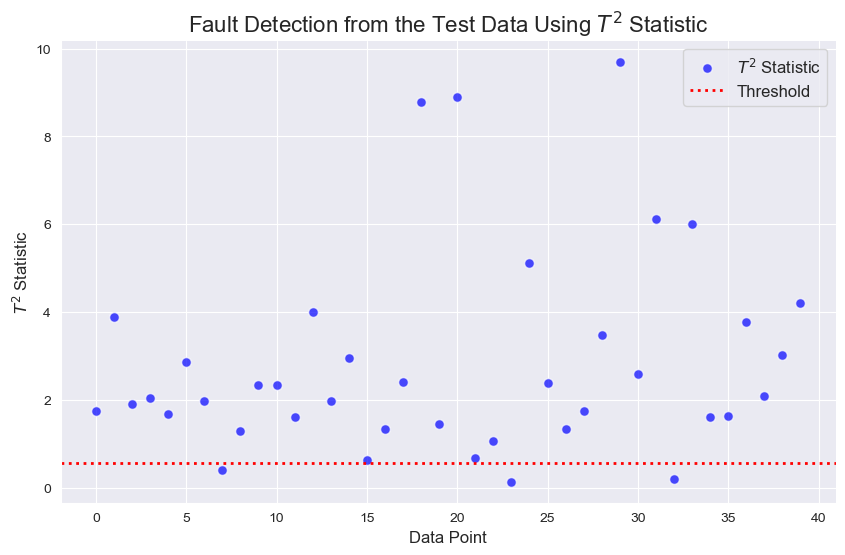

In [31]:
# Set up a larger figure size and grid layout
plt.figure(figsize=(10, 6))

# Create a scatter plot of the T^2 statistic values
plt.scatter(range(len(T_squared_test)), T_squared_test, label='$T^2$ Statistic', c='blue', s=50, alpha=0.7, edgecolors='white')

# Plot the threshold as a solid line with width=2
plt.axhline(y=fault_threshold, linestyle='dotted', color='red', linewidth=2, label='Threshold')

# Add labels and title to the plot
plt.xlabel('Data Point', fontsize=12)
plt.ylabel('$T^2$ Statistic', fontsize=12)
plt.title('Fault Detection from the Test Data Using $T^2$ Statistic', fontsize=16)

# Add a legend with custom fontsize
plt.legend(loc='best', fontsize=12)

# Remove top and right spines for better aesthetics
sns.despine(top=True, right=True)

# Show the plot
plt.show()


### Conclusion on Fault Identification : 

##### 1. In the world of multivariate process monitoring, PCA combined with Hotelling’s $T^2$ statistic is a powerful methodology for detecting faults or anomalies in the system. In essence, PCA reduces the dimensionality of the data, thereby eliminating the potential issues caused by multicollinearity and helping to clarify the structure of the data. Hotelling’s $T^2$ statistic, on the other hand, is a multivariate measure of the deviation of a given observation from the mean of the observations, serving as a generalized form of the t-statistic for multivariate data.
###### 2. In the context of our analysis, we employed these two techniques to identify potential faults in our data. Our plot showcases data points along with the $T^2$ statistic threshold represented by a red dotted line. The points that fall beyond this threshold can be considered potential fault data points. They deviate from the general behavior of our dataset in the PCA transformed space, indicating possible anomalies in the original multivariate data.
###### 3. In essence, the points lying outside this boundary represent conditions or states where the system behaves differently than usual. Identifying these states is crucial in process monitoring and control to prevent suboptimal operation or even system failure.